In [3]:
%load_ext autoreload
%autoreload 2 
# !apt-get install -y xvfb
import time
import torch
from collections import Counter
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
# https://www.youtube.com/watch?v=QLIkOtKS4os --> creating custom dataset in pytorch geometric
from torch.utils.data import Dataset, random_split
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
import torch_geometric
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import pickle
import random
import os

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.preprocessing import LabelEncoder

### Utility Functions

In [4]:


def set_device_and_seed(GPU=True, seed=0, gpu_name = "cuda:0"):
    torch.cuda.is_available()
    if GPU:
        device = torch.device(gpu_name if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device("cpu")
    print(f'Using {device}')

    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed(seed)

        
    set_seed(seed)
    
    return device

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print(f"Setting torch, cuda, numpy and random seeds to {seed}")


def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

    
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [5]:
# Setting random seed and device
GPU = True # Choose whether to use GPU
device =set_device_and_seed(GPU=False, seed=0, gpu_name='cuda:0')

Using cpu
Setting torch, cuda, numpy and random seeds to 0


### Load Data


In [6]:
orig_df = pd.read_csv(os.path.abspath("/home/sneha/e5_cleaned_QC.csv"))


In [7]:
label_df = pd.read_csv(os.path.abspath("/home/sneha/MESA_Exam5_airway_variants.csv"))

####  Class distribution of the labels 

In [8]:
pilot_df_w_labels = orig_df.merge(label_df, on='idno', how='left')
# drop nan labels
print(len(pilot_df_w_labels), pilot_df_w_labels.idno.nunique())
pilot_df_w_labels.dropna(subset='LL_1', inplace=True)

print(len(pilot_df_w_labels), pilot_df_w_labels.idno.nunique())

192348 2909
191383 2890


In [9]:
print("Label frequency distribution")
label_freq = pilot_df_w_labels.groupby('LL_1').agg({'idno':lambda x:x.nunique()})
total = label_freq.idno.sum()
label_freq['percent'] = label_freq.idno.apply(lambda x:np.round(100*x/total, 2))
label_freq.rename({'idno':'#participants'}, inplace=True)
label_freq

Label frequency distribution


,idno,percent
LL_1,,
Abs. RB7,163,5.64
Acc. B*,412,14.26
Acc. LB7,42,1.45
Standard,2101,72.70
Unclass.,172,5.95


In [10]:
# drop unclass
pilot_df_w_labels = pilot_df_w_labels.loc[~(pilot_df_w_labels.LL_1.str.lower().str.contains('unclass'))]


In [11]:
# make labels binary
binary_label = {
    
    'Abs. RB7': 1,
'Acc. B*': 1,
'Acc. LB7':1,
'Standard':0
    
    
}
pilot_df_w_labels['binaryLL_1'] = pilot_df_w_labels.LL_1.apply(lambda x: binary_label[x])

binary_label_freq = pilot_df_w_labels.groupby('binaryLL_1').agg({'idno':lambda x:x.nunique()})
total = binary_label_freq.idno.sum()
binary_label_freq['percent'] = binary_label_freq.idno.apply(lambda x:np.round(100*x/total, 2))
binary_label_freq.rename({'idno':'#participants'}, inplace=True)
binary_label_freq

,idno,percent
binaryLL_1,,
0,2101,77.3
1,617,22.7


In [12]:
pilot_df = pilot_df_w_labels.copy()
len(pilot_df)

179948

# FEATURE ENGINEERING
- todo choose features and normalise here
- anomaly detection used direction, coords, level, bottom-up level, length (distance from coords to furthest child), number descendents + image feature which we dont have


## Make a graph sample & visualise in networkx

/tmp/ipykernel_32277/1715783808.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_w_coords['anatomicalname'] = tree_w_coords['anatomicalname'].apply(lambda x:"" if ('unnamed' in x) or (x == '-') else x)


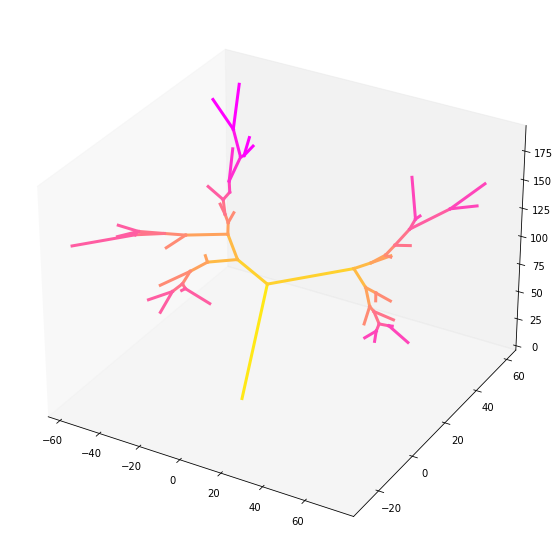

In [44]:
tree_w_coords = pilot_df[(pilot_df.idno ==3011950)]
val_min = -1
val_max=10
# cmap = mpl.cm.RdYlGn#.reversed()
cmap = mpl.colormaps['spring'].reversed()
norm = mpl.colors.Normalize(vmin=val_min, vmax=val_max)


# simpliofy names
tree_w_coords['anatomicalname'] = tree_w_coords['anatomicalname'].apply(lambda x:"" if ('unnamed' in x) or (x == '-') else x)

row = tree_w_coords.iloc[0]
# quick visualisation of tree

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for i in range(len(tree_w_coords)):
    row = tree_w_coords.iloc[i]
    ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.y], [row.parent_loc_z, row.z], linestyle='-',linewidth=3, color= cmap(norm(row.weibel_generation)), label=row.anatomicalname)
ax.grid(False)
ax.set_facecolor(color=(1,1,1))
plt.show()

In [45]:
# nodes and features
nodes = list(zip(tree_w_coords.endbpid, tree_w_coords[['x', 'y', 'z','dircosx', 'dircosy', 'dircosz','angle','weibel_generation', 'lobe', 'sublobe']].to_dict(orient='records')))
nodes =[(-1,
  {'x': 0,
   'y': 0,
   'z': 0,
   'dircosx':0,
   'dircosy':0,
   'dircosz':0,
   'lobe':0,
   'sublobe':0,
   'weibel_generation': -1,
   'angle': 0.0})]+nodes

In [46]:
# edges and features: TODO include all features relevant + NORMALISE
edges = list(zip(tree_w_coords.startbpid, tree_w_coords.endbpid))
edges_with_features = dict(zip(edges,tree_w_coords[['centerlinelength', 'avginnerarea']].to_dict(orient='records')))
edges_with_features

{(-1.0, 1.0): {'centerlinelength': 82.0393, 'avginnerarea': 237.704},
 (1.0, 6.0): {'centerlinelength': 23.6456, 'avginnerarea': 140.567},
 (1.0, 7.0): {'centerlinelength': 50.79, 'avginnerarea': 97.7085},
 (6.0, 19.0): {'centerlinelength': 19.755, 'avginnerarea': 108.494},
 (6.0, 18.0): {'centerlinelength': 13.9716, 'avginnerarea': 60.5322},
 (7.0, 11.0): {'centerlinelength': 12.0985, 'avginnerarea': 60.5433},
 (7.0, 10.0): {'centerlinelength': 8.43446, 'avginnerarea': 146.8},
 (10.0, 15.0): {'centerlinelength': 9.92149, 'avginnerarea': 40.2393},
 (10.0, 14.0): {'centerlinelength': 8.46466, 'avginnerarea': 24.9217},
 (11.0, 17.0): {'centerlinelength': 10.5259, 'avginnerarea': 38.2976},
 (11.0, 16.0): {'centerlinelength': 11.1299, 'avginnerarea': 28.5548},
 (15.0, 22.0): {'centerlinelength': 7.0526, 'avginnerarea': 34.5042},
 (15.0, 23.0): {'centerlinelength': 7.63582, 'avginnerarea': 19.8735},
 (16.0, 25.0): {'centerlinelength': 14.131, 'avginnerarea': 11.3993},
 (16.0, 24.0): {'cente

In [75]:


g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

nx.set_edge_attributes(g,edges_with_features)
# print(g.edges(data=True))
# print(g.nodes(data=True))
# 2D projection of tree (excluding the trachea itself)
col = nx.subgraph_centrality(g)
display(col)

val_min = min(col.values())
val_max=max(col.values())
# cmap = mpl.cm.RdYlGn#.reversed()
cmap = mpl.colormaps['spring'].reversed()
norm = mpl.colors.Normalize(vmin=val_min, vmax=val_max)
cmap_nodes = [cmap(norm(col[node])) for node in g.nodes()]

# cmap_nodes = [cmap(norm(g.nodes[node]['weibel_generation']))for node in g.nodes() if not len(g.nodes[node])==0]
# labels = {node:g.nodes[node]['anatomicalname'] for node in g.nodes() if (not len(g.nodes[node])==0) & (len(g.nodes[node]['anatomicalname']) > 1)}
edge_labels = {edge:tree_w_coords.loc[tree_w_coords.endbpid == edge[1]]['anatomicalname'].item() for edge in g.edges() }
# print('edge', edge_labels)
pos = nx.planar_layout(g, scale=1, center=(0,0), dim=2)

f, ax = plt.subplots(figsize=(10,10))
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
nx.draw(g,pos=pos, with_labels=False,node_color=cmap_nodes, ax=ax)
nx.draw_networkx_edge_labels(g, pos,
                          edge_labels,
                             font_color='k',
                             font_size='10',
                          label_pos=0.5,
                          )
plt.title(f'TRAINING GRAPH: {tree_w_coords.idno.unique()}')
# plt.colorbar(cmap_nodes, cax=cax, orientation='vertical')
plt.show()

NetworkXNotImplemented: not implemented for directed type

[11.0, 17.0, 26.0, 45.0, 75.0, 112.0]
5459    82.03930
5460    23.64560
5461    50.79000
5462    19.75500
5463    13.97160
          ...   
5522     1.83759
5523    25.44430
5524    21.26500
5525     5.47880
5526    11.57660
Name: centerlinelength, Length: 68, dtype: float64
65.74319


True

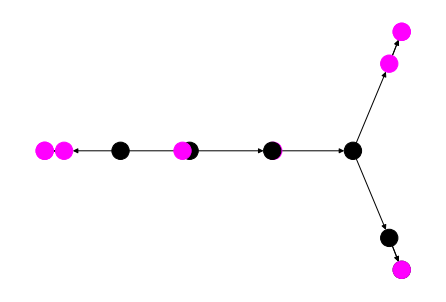

In [84]:
desc_nodes = nx.descendants(g, 11) # this is useful


mini_g = g.subgraph(nodes=list(desc_nodes)+[11])
nodes =nx.dag_longest_path(mini_g, weight='centerlinelength')
print(nodes)
color = [(0,0,0)  if node in nodes else (1,0,1) for node in mini_g.nodes()]
print(tree_w_coords.centerlinelength)
print(tree_w_coords.loc[tree_w_coords.endbpid.isin(nodes)]['centerlinelength'].sum())
nx.draw_spectral(mini_g, node_color = color)
nx.is_tree(mini_g)
# col = nx.betweenness_centrality(g,  endpoints=True)
# closeness not that helpful, information etc. not for directed


## Pytorch Dataset for Geometric

- TODO drop the unclassified examples
- MAKE BINARY LABELS
- WEIGHTED LOSS
- SPLIT TRAIN TEST
- LOOK INTO BETTER GCNS
- FEATURE ENGINEERING AND NORMALISATION

In [16]:

# g = torch_geometric.utils.to_networkx(# torch dataset, to_undirected=False)
# nx.draw_planar(g, with_labels=True)
# g.edges()


In [53]:
class CustomDataset(torch_geometric.data.Dataset):
    def __init__(self,root, filename_data, filename_labels, test=False, transform=None, pre_transform=None):
        '''
        root = where dataset should be stored, folder is split into raw_dir and processed_dir
        '''
        # super(CustomDataset, self).__init__(root, transform, pre_transform)
        self.test = test
        self.filename_data = filename_data
        self.filename_labels = filename_labels
        super(CustomDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return self.filename_data
    
    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
    
    def _download(self):
        pass
    
    def process(self):
        self.data = pd.read_csv(os.path.abspath(self.raw_paths[0]))
        label_df = self._process_labels()
        graph_ids = self.data.idno.unique()
        
        for i, idno in tqdm(list(enumerate(graph_ids))):
            # iterate through each patricipant
            df = self.data.loc[self.data.idno == idno].copy().reset_index()
            # build a graph out of the df with node features, edge_features and edge_adjacency
            x = self._get_node_features(df)
            edge_adjacency = self._get_edge_adjacency(df)
            edge_features = self._get_edge_features(df)
            y = self._get_label(idno, label_df)
            data = Data(x=x,
                        edge_index=edge_adjacency,
                        edge_attr = edge_features,
                        y = y
                       )
            if self.test:
                torch.save(data, 
                            os.path.join(self.processed_dir, 
                                         f'data_test_{i}.pt'))
            else:
                 torch.save(data, 
                            os.path.join(self.processed_dir, 
                                         f'data_{i}.pt'))
    
    
    def _process_labels(self):
        #(NOTE THIS IS WRONG YOU NEED TO DROP UNALBELLED)
        label_df = pd.read_csv(os.path.abspath(self.filename_labels))
        # binarise 
        label_df.LL_1 = label_df.LL_1.apply(lambda x: 'Standard' if x == 'Standard' else 'Anomaly')
        # categorical variables
        le = LabelEncoder()
        le.fit(label_df.LL_1)
        label_df['LL_1_encoded'] = le.transform(label_df.LL_1)
        # drop rows not matching to data ids
        data_df =  pd.read_csv(os.path.abspath(self.filename_data))
        label_df_small = label_df.loc[label_df.idno.isin(data_df.idno.unique())]
        print("# Graphs", len(label_df_small), "Label Frequency", Counter(label_df_small['LL_1_encoded'].to_list()))
        self.class_proportions = {k:v/len(label_df_small) for k,v in Counter(label_df_small['LL_1_encoded'].to_list()).items()}
        print(self.class_proportions)
        return label_df_small
    
    def _get_edge_adjacency(self,df):
        # NOTE pytorch requires nodes to start from 0 and go up in integers so need to remap start and end bpids from df
        relabel_map = {v:k+1 for k,v in df.endbpid.to_dict().items()}
        # add trachea map (node 0)
        relabel_map[-1] = 0
        # apply relabelling to source and end nodes
        source_nodes = df.startbpid.apply(lambda x: relabel_map[x]).to_list()
        end_nodes = df.endbpid.apply(lambda x: relabel_map[x]).to_list()
        # return in COO format
        return torch.tensor([source_nodes, end_nodes], dtype=torch.long)

    def _get_node_features(self,df):
        df_w_coords = _get_coords(df)
        # add trachea to nodes
        # currently usnig as features 
        x_list_plus_trachea = [[0,0,0,-1]]+ df_w_coords.apply(lambda row:row[['x','y','z', 'weibel_generation']].to_list(), axis=1).to_list() # here only node features are pos and weibel gen
        x = torch.tensor(x_list_plus_trachea, dtype=torch.float)
        # normalise features
        scaler = StandardScaler()
        scaler.fit(x)
        x_norm = scaler.transform(x)
        return torch.tensor(x_norm, dtype=torch.float)

    def _get_edge_features(self,df):
        # get matrix of shape [# edges, edge feature size]
        edge_features = df[['centerlinelength', 'avginnerarea']].values
        # normalise
        scaler = StandardScaler()
        scaler.fit(edge_features)
        edge_norm = scaler.transform(edge_features)
        return torch.tensor(edge_norm, dtype=torch.float)

    def _get_label(self, idno, label_df):
        return torch.tensor(label_df.loc[label_df.idno==idno,
                 'LL_1_encoded'].values, dtype=torch.int64)
    
    def len(self):
        return int(self.data.idno.nunique())
    
    def get(self, idx):
        '''
        Equivalent to __getitem__ in pytorch
        '''
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data
            

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
        
my_data  = CustomDataset('data/', '/home/sneha/airway_tree_pilot_clean.csv',"/home/sneha/MESA_Exam5_airway_variants.csv")

Processing...


# Graphs 227 Label Frequency Counter({1: 177, 0: 50})
{1: 0.7797356828193832, 0: 0.22026431718061673}


100%|█████████████████████████████████████████████████████████████████████████████████| 227/227 [00:34<00:00,  6.51it/s]
Done!


In [56]:
train_loader = DataLoader(my_data, batch_size=16, shuffle=True)
print(train_loader.dataset.class_proportions)

{1: 0.7797356828193832, 0: 0.22026431718061673}


In [19]:
m = nn.Softmax()
input = torch.randn(2, 3)
print(input)
print(m(input))
m(input).argmax(dim=1)

tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986]])
tensor([[0.8446, 0.1349, 0.0205],
        [0.7511, 0.1438, 0.1051]])


/tmp/ipykernel_9786/4204858206.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(m(input))
/tmp/ipykernel_9786/4204858206.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  m(input).argmax(dim=1)


tensor([0, 0])

### MODELS

In [ ]:

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        
        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)
    
    
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model = GAT().to(device)
data = dataset[0].to(device)
print(data)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    print(out.shape)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    if epoch%200 == 0:
        print(loss)
    
    loss.backward()
    optimizer.step()
    
    

In [31]:


class GCN(torch.nn.Module):
    def __init__(self,in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return torch.tensor(x)

def _count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad == True)
    
model = GCN(in_channels=4, hidden_channels=8, out_channels=1)
print(model)
print(list(model.parameters()))

GCN(
  (conv1): GCNConv(4, 8)
  (conv2): GCNConv(8, 8)
  (conv3): GCNConv(8, 8)
  (lin): Linear(in_features=8, out_features=1, bias=True)
)
[Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[-0.2659, -0.1007, -0.3153, -0.0881],
        [ 0.6361, -0.6798, -0.3345,  0.6009],
        [-0.0372, -0.1469,  0.2378, -0.2987],
        [ 0.2904, -0.4362, -0.2126,  0.5412],
        [ 0.0693, -0.5593,  0.4248, -0.4699],
        [-0.0456, -0.0020, -0.3116,  0.3165],
        [-0.0699,  0.3861,  0.3593, -0.5530],
        [ 0.5281,  0.0176,  0.5583,  0.4401]], requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[-0.3485,  0.2862, -0.5823, -0.2902,  0.2441,  0.5731,  0.3985,  0.2532],
        [-0.4325,  0.1859, -0.2230,  0.0355, -0.0784,  0.5731,  0.3995,  0.0641],
        [-0.5954,  0.4798,  0.4201,  0.2081, -0.6052, -0.4069,  0.3224, -0.5745],
        [ 0

In [21]:
loss = nn.CrossEntropyLoss()
input_ = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
print(input)
print(target)
loss(input_, target)

tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986]])
tensor([0, 3, 2])


tensor(2.7728, grad_fn=<NllLossBackward0>)

Using cpu
Setting torch, cuda, numpy and random seeds to 0
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_9786/2828724317.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.55it/s]


Epoch: 0, Loss: 1.39


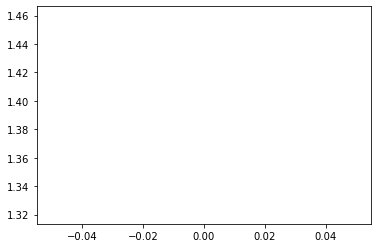

Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_9786/2828724317.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.83it/s]


Epoch: 1, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.30it/s]


Epoch: 2, Loss: 1.42
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.85it/s]


Epoch: 3, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.36it/s]


Epoch: 4, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.19it/s]


Epoch: 5, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.15it/s]


Epoch: 6, Loss: 1.44
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.12it/s]


Epoch: 7, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.73it/s]


Epoch: 8, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.21it/s]


Epoch: 9, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.33it/s]


Epoch: 10, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.25it/s]


Epoch: 11, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.45it/s]


Epoch: 12, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.62it/s]


Epoch: 13, Loss: 1.45
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.40it/s]


Epoch: 14, Loss: 1.42
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.73it/s]


Epoch: 15, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.09it/s]


Epoch: 16, Loss: 1.45
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.29it/s]


Epoch: 17, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.93it/s]


Epoch: 18, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.17it/s]


Epoch: 19, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.03it/s]


Epoch: 20, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.23it/s]


Epoch: 21, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.15it/s]


Epoch: 22, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.71it/s]


Epoch: 23, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.86it/s]


Epoch: 24, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.10it/s]


Epoch: 25, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.89it/s]


Epoch: 26, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.50it/s]


Epoch: 27, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.45it/s]


Epoch: 28, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.88it/s]


Epoch: 29, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.04it/s]


Epoch: 30, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.50it/s]


Epoch: 31, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.93it/s]


Epoch: 32, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.56it/s]


Epoch: 33, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.30it/s]


Epoch: 34, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.35it/s]


Epoch: 35, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.37it/s]


Epoch: 36, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.28it/s]


Epoch: 37, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.54it/s]


Epoch: 38, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.90it/s]


Epoch: 39, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.39it/s]


Epoch: 40, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.36it/s]


Epoch: 41, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.90it/s]


Epoch: 42, Loss: 1.44
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.13it/s]


Epoch: 43, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.19it/s]


Epoch: 44, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.98it/s]


Epoch: 45, Loss: 1.42
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.83it/s]


Epoch: 46, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.96it/s]


Epoch: 47, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.52it/s]


Epoch: 48, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.36it/s]


Epoch: 49, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.43it/s]


Epoch: 50, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.02it/s]


Epoch: 51, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.63it/s]


Epoch: 52, Loss: 1.46
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.64it/s]


Epoch: 53, Loss: 1.42
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.13it/s]


Epoch: 54, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.82it/s]


Epoch: 55, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.68it/s]


Epoch: 56, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.86it/s]


Epoch: 57, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.29it/s]


Epoch: 58, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.93it/s]


Epoch: 59, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.47it/s]


Epoch: 60, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.22it/s]


Epoch: 61, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.09it/s]


Epoch: 62, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.21it/s]


Epoch: 63, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.18it/s]


Epoch: 64, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.92it/s]


Epoch: 65, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.90it/s]


Epoch: 66, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.77it/s]


Epoch: 67, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.48it/s]


Epoch: 68, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.53it/s]


Epoch: 69, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.24it/s]


Epoch: 70, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.67it/s]


Epoch: 71, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.45it/s]


Epoch: 72, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.07it/s]


Epoch: 73, Loss: 1.42
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.64it/s]


Epoch: 74, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.91it/s]


Epoch: 75, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.34it/s]


Epoch: 76, Loss: 1.44
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.14it/s]


Epoch: 77, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.55it/s]


Epoch: 78, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.08it/s]


Epoch: 79, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.13it/s]


Epoch: 80, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.92it/s]


Epoch: 81, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.30it/s]


Epoch: 82, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.36it/s]


Epoch: 83, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.54it/s]


Epoch: 84, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.16it/s]


Epoch: 85, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.03it/s]


Epoch: 86, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.96it/s]


Epoch: 87, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.86it/s]


Epoch: 88, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.46it/s]


Epoch: 89, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.85it/s]


Epoch: 90, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.09it/s]


Epoch: 91, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.66it/s]


Epoch: 92, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.34it/s]


Epoch: 93, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.79it/s]


Epoch: 94, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.59it/s]


Epoch: 95, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.74it/s]


Epoch: 96, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.88it/s]


Epoch: 97, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.53it/s]


Epoch: 98, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.99it/s]

Epoch: 99, Loss: 1.40


In [62]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



def train_one_epoch(epoch, model, train_loader, optimizer, device, weighted_loss=True):
    class_proportions = train_loader.dataset.class_proportions
    print("Class proportions", class_proportions)
    # Enumerate over the data
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    model.train()
    model.to(device)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        # pred = model(batch.x.float(), 
        #                         batch.edge_attr.float(),
        #                         batch.edge_index, 
        #                         batch.batch) 
        pred = torch.sigmoid(model(batch.x, batch.edge_index, batch.batch))
        # Calculating the loss and gradients
        if weighted_loss:
            weights = batch.y.float().detach().clone()
            counts = weights.unique(return_counts=True)
            for idx in range(len(counts[0])):
                idx = int(idx)
                target = int(counts[0][idx].item())
                class_weight = 1 / class_proportions[target]
                # go through the classes in the batch
                # for values in the target tensor which have class 0/1,
                # replace with inverse proportion for that class
                weights[weights == counts[0][idx]] = class_weight
        else:
            weights = None
        loss =  F.binary_cross_entropy(pred.squeeze(), batch.y.float(), weight=weights)
        loss.requires_grad = True
        loss.backward()  
        optimizer.step()  
        # Update tracking
        running_loss += loss.item()
        # counting batches
        step += 1
    # loss average per epoch
    return running_loss/step

device = set_device_and_seed(GPU=False, seed=0)
plotting_dict_train = {}
plotting_dict_train['loss'] = []
plot_every = 100
num_epochs = 100
for i in range(num_epochs):
    loss = train_one_epoch(i, model, train_loader, optimizer, device, weighted_loss=True)
    plotting_dict_train['loss'].append(loss)
    print('Epoch: {}, Loss: {:.2f}'.format(i, loss))
    if i % plot_every == 0:
        plt.figure()
        plt.plot(np.arange(len(plotting_dict_train['loss'])), plotting_dict_train['loss'])
        plt.show()
        

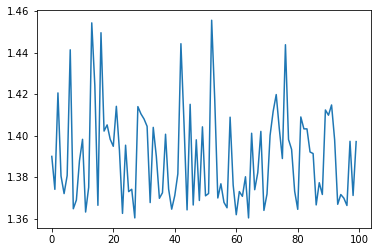

In [63]:
plt.figure()
plt.plot(np.arange(len(plotting_dict_train['loss'])), plotting_dict_train['loss'])